In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('gpu')

In [5]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import arviz as az 
import numpy as np
import jax.numpy as jnp
import tensorflow_probability.substrates.jax.distributions as tfd
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey
from leaguedata.inference import numpyro_model
from leaguedata.model import generate_coinflip_history, generate_nasty_loser_q, generate_obvious_loser_q

In [25]:
def plot_history(matrix, name=None, lane=None, kda=None, start=None, save_to=None):


    name = name if name is not None else np.empty(mock_history.shape, dtype=str)
    lane = lane if lane is not None else np.empty(mock_history.shape, dtype=str)
    kda = kda if kda is not None else np.empty(mock_history.shape, dtype=str)
    start = start if start is not None else np.empty(mock_history.shape, dtype=str)
    
    heatmap = go.Heatmap(
        z=matrix.astype(float),
        customdata=np.dstack((name, matrix.astype(bool), lane, kda, start)),
        hovertemplate='<b>Summoner: %{customdata[0]}</b><br>'
                      'Win: %{customdata[1]}<br>'
                      'Lane: %{customdata[2]}<br>'
                      'KDA: %{customdata[3]:.2f} <br>'
                      'Start: %{customdata[4]}',
        colorscale=[[0, 'rgba(199, 21, 133, 0.8)'], [1, 'rgba(60, 179, 113, 0.8)']],
        name="History",
        showscale=False
    )
    
    # Create a Figure and update layout for a cleaner look
    fig = go.Figure(data=[heatmap])
    fig.update_layout(  # Hiding x-axis ticks
        yaxis = go.layout.YAxis(
            title = 'Individual players',
            showticklabels=False
        ),
        margin=dict(l=20, r=20, t=20, b=20),
        width=700, height=800/3,
        xaxis_title=f'History of {matrix.shape[1]} games',
    )
    
    # Show plot
    fig.show()

    if save_to is not None:
        with open(save_to, "w") as f:
            f.write(fig.to_json())

    return fig

# Coinflip History

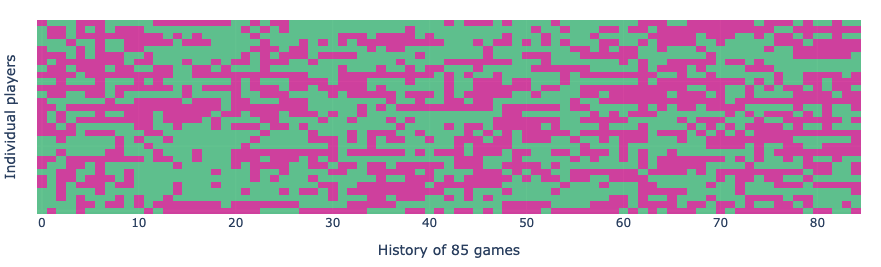

In [26]:
mock_history = generate_obvious_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history);

In [77]:
import arviz as az 
import tensorflow_probability.substrates.jax.distributions as tfd
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey, key, fold_in
from leaguedata.model import DMCModel

mock_history = generate_obvious_loser_q(number_of_players=100, number_of_games=85)

dict_of_id = {}

for i in range(6, -1, -1):

    markov_util = DMCModel(i)
    kernel = NUTS(numpyro_model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=5, chain_method='vectorized')
    mcmc.run(fold_in(key(0), i), markov_util, mock_history)
    
    dict_of_id[f'{i} games'] = az.from_numpyro(mcmc)
    
    assert np.all(az.rhat(dict_of_id[f'{i} games'])<1.01)

sample: 100%|██████████| 3000/3000 [00:10<00:00, 276.79it/s]


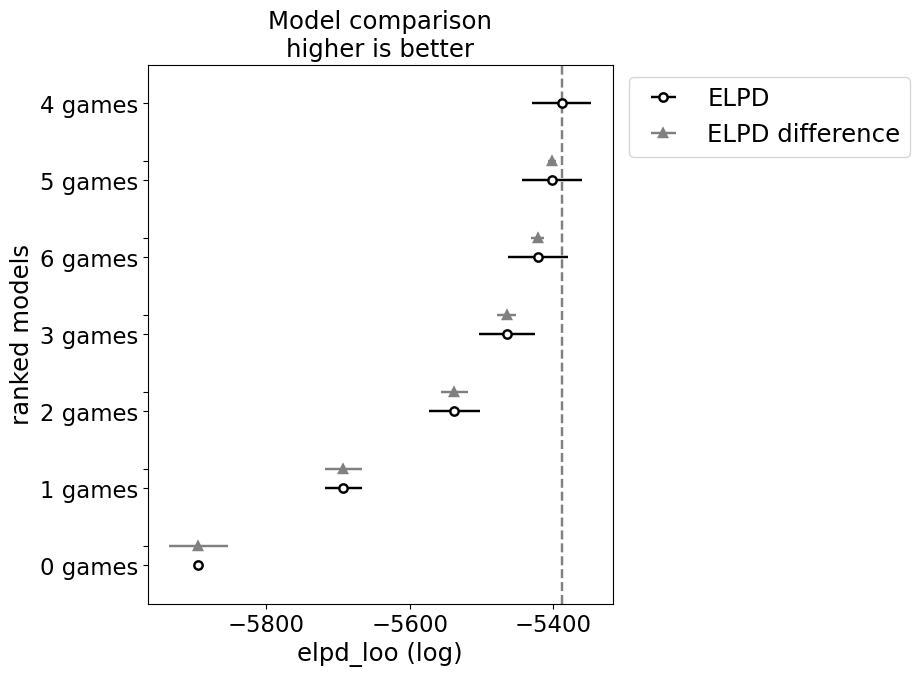

In [78]:
az.plot_compare(az.compare(dict_of_id));

In [ ]:
az.compare(dict_of_id)

In [101]:
import numpy as np
import matplotlib.pyplot as plt

def plot_compare(comp_df):
    # Configuration settings for the plot
    plot_kwargs = {
        "color_ic": "k",
        "marker_ic": "o",
        "marker_fc": "white",
        "color_dse": "grey",
        "marker_dse": "^",
        "ls_min_ic": "--",
        "color_ls_min_ic": "grey"
    }
    linewidth = 2
    information_criterion = 'elpd_loo'

    # Prepare y-ticks and labels
    n_models = len(comp_df)
    yticks_pos = np.arange(n_models) * -1.5  # Increased spacing between ticks
    labels = comp_df.index.tolist()

    # Plotting
    fig, ax = plt.subplots()
    ax.errorbar(
        x=comp_df[information_criterion],
        y=yticks_pos + 0.1,
        xerr=comp_df['se'],
        label="ELPD",
        color=plot_kwargs["color_ic"],
        fmt=plot_kwargs["marker_ic"],
        mfc=plot_kwargs["marker_fc"],
        mew=linewidth,
        lw=linewidth,
    )

    ax.errorbar(
        x=comp_df[information_criterion].iloc[1:],
        y=yticks_pos[1:] -0.1,  # Apply the same spacing to these points
        xerr=comp_df['dse'][1:],
        label="ELPD difference",
        color=plot_kwargs["color_dse"],
        fmt=plot_kwargs["marker_dse"],
        mew=linewidth,
        elinewidth=linewidth,
    )

    ax.axvline(
        x=comp_df[information_criterion].iloc[0],
        ls=plot_kwargs["ls_min_ic"],
        color=plot_kwargs["color_ls_min_ic"],
        lw=linewidth,
    )

    ax.set_yticks(yticks_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('ELPD LOO (log)')
    plt.legend()
    plt.show()

    return ax


In [125]:
import plotly.graph_objects as go
import numpy as np

def plot_compare_plotly(comp_df):
    plot_kwargs = {
        "color_ic": "black",
        "marker_ic": "circle",
        "marker_fc": "white",
        "color_dse": "grey",
        "marker_dse": "triangle-up",
        "ls_min_ic": "dash",
        "color_ls_min_ic": "grey"
    }
    linewidth = 2
    information_criterion = 'elpd_loo'

    n_models = len(comp_df)
    yticks_pos = np.arange(n_models)[::-1] * -1.5  # Increased spacing between ticks
    labels = comp_df.index.tolist()

    # Create the figure
    fig = go.Figure()

    # Add the ELPD error bars
    fig.add_trace(go.Scatter(
        x=comp_df[information_criterion],
        y=yticks_pos + 0.1,
        error_x=dict(type='data', array=comp_df['se'], thickness=linewidth),
        mode='markers+text',
        marker=dict(color=plot_kwargs["color_ic"], symbol=plot_kwargs["marker_ic"], size=10, line=dict(color=plot_kwargs["marker_fc"], width=linewidth)),
        name="ELPD"
    ))

    # Add the ELPD difference error bars
    fig.add_trace(go.Scatter(
        x=comp_df[information_criterion].iloc[1:],
        y=yticks_pos[1:] - 0.1,
        error_x=dict(type='data', array=comp_df['dse'][1:], thickness=linewidth),
        mode='markers+text',
        marker=dict(color=plot_kwargs["color_dse"], symbol=plot_kwargs["marker_dse"], size=10),
        name="ELPD difference"
    ))

    # Add a vertical line
    fig.add_shape(type="line",
        x0=comp_df[information_criterion].iloc[0], y0=min(yticks_pos) - 1, x1=comp_df[information_criterion].iloc[0], y1=max(yticks_pos) + 1,
        line=dict(color=plot_kwargs["color_ls_min_ic"], width=linewidth, dash=plot_kwargs["ls_min_ic"]),
    )

    # Update axes properties
    fig.update_layout(
        xaxis_title='ELPD LOO (log)',
        yaxis_title='Model ranking',
        yaxis=dict(
            tickmode='array',
            tickvals=yticks_pos,
            ticktext=labels
        ),
        width=500, height=500,
        yaxis_autorange='reversed',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ) # This automatically inverts the y-axis
    )

    fig.show()

    return fig

# Usage
# comp_df should be a pandas DataFrame that includes 'elpd_loo', 'se', and 'dse' columns
# Example: plot_compare_plotly(comp_df)


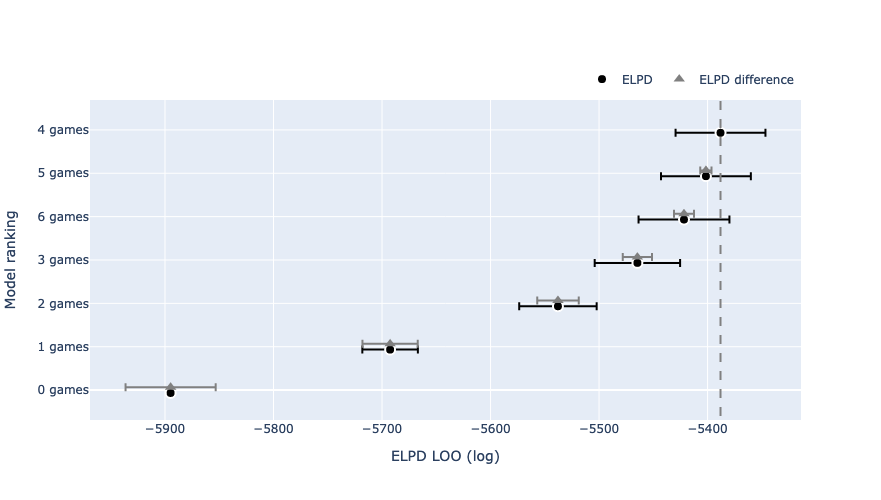

In [126]:
plot_compare_plotly(az.compare(dict_of_id));

# SOFT LOSERQ

In [ ]:
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey
from model import DMCModel

markov_util_ref = DMCModel(4)

probs = jnp.empty((2**4))
probs_keys = {0. : 0.25, 0.25:1/3, 0.5:0.5, 0.75:2/3, 1.:0.75}

for i, state in enumerate(markov_util_ref.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state)/4])
    
mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(200, seed=PRNGKey(42))
mock_history = np.apply_along_axis(markov_util_ref.categorical_serie_to_binary, 1, mock_history_encoded)
plt.matshow(mock_history);

In [ ]:
from jax.random import split
from tqdm.notebook import tqdm

key_ref = PRNGKey(42)

mock_history_list = []
importance_list = []

for history_in_tier in list(history.values())[0:8]:

    for puuid, true_history in tqdm(history_in_tier.items()):

        key, key_ref = split(key_ref, 2)

        probs = jnp.empty((2**4))

        importance = pert(0, 0.05, 1) #np.random.beta(a=2, b=5)
        probs_keys = {0. : 0.5 - 0.375*importance, 
                      0.25:0.5 - 0.125*importance, 
                      0.5:0.5, 
                      0.75:0.5 + 0.125*importance, 
                      1.:0.5 + 0.375*importance}
        
        for i, state in enumerate(markov_util_ref.get_states()):
            probs = probs.at[i].set(probs_keys[sum(state)/4])
            
        mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(1, seed=key)[0]
        mock_history = markov_util_ref.categorical_serie_to_binary(mock_history_encoded)

        mock_history_list.append(mock_history)
        importance_list.append(importance)

# plt.matshow(np.asarray(mock_history_list)[np.argsort(importance_list)]);

In [ ]:
import jax 
from tensorflow_probability.substrates.jax import distributions as tfd

In [ ]:
from leaguedata.model import generate_coinflip_history, DMCModel
mock_history = generate_coinflip_history()

In [ ]:


dict_of_id = {}

for i in range(4, -1, -1):
    
    markov_util = DMCModel(i)
    kernel = NUTS(numpyro_model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='parallel')#'vectorized')
    mcmc.run(PRNGKey(0), markov_util, mock_history)
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)
    
    assert np.all(az.rhat(dict_of_id[str(i)])<1.01)

In [ ]:
az.plot_compare(az.compare(dict_of_id));

# TRUE DATA

In [ ]:
import arviz as az 
import jax
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

tier_list = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER',
             'CHALLENGER']

dict_of_id = {}

local_history = history
smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], local_history))
flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], local_history))
observed_history = jnp.asarray(flat_tree)

for i in range(6, -1, -1):
    
    markov_util = DMCModel(i)
    encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
    encoded_history = jax.device_put(encoded_history)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
                
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
    mcmc.run(
        PRNGKey(0)
    )
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

az.plot_compare(az.compare(dict_of_id));

In [ ]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['1']
markov_util = DMCModel(1)
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

In [ ]:
cc.plotter.plot_distributions();

In [ ]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4']
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util_ref.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(Truth(location={str(state) + '-> (1)':probs_keys[sum(state)/4] for i, state in enumerate(markov_util_ref.get_states())}, line_style=":", color="red"))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""